# gpt-o3-mini

In [1]:
model_name = "o3-mini-2025-01-31"

In [2]:
import os
os.environ['PATH_TO_ENV'] = ".env_o3-mini-2025-01-31"

In [3]:
from three_stages_1 import ThreeStagesGraphGenerator as Generator
from three_stages_0i import ThreeStagesGraphGenerator as GeneratorI0

graph_generator = Generator(model_name) # To generate 1st graph from one dialogue
graph_generator_llm = GeneratorI0() # To add dialogue to existing graph with LLM

e:\Projects\chatsky-llm-autoconfig\.venv\lib\site-packages\pydantic\_internal\_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(
e:\Projects\chatsky-llm-autoconfig\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


parser=PydanticOutputParser(pydantic_object=<class 'three_stages_1.DialogueNodes'>) retry_chain=PromptTemplate(input_variables=['completion', 'error', 'instructions'], input_types={}, partial_variables={}, template='Instructions:\n--------------\n{instructions}\n--------------\nCompletion:\n--------------\n{completion}\n--------------\n\nAbove, the Completion did not satisfy the constraints given in the Instructions.\nError:\n--------------\n{error}\n--------------\n\nPlease try again. Please only respond with an answer that satisfies the constraints laid out in the Instructions:')
| ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000162FE334160>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000162FE336A70>, root_client=<openai.OpenAI object at 0x00000162FE1E62C0>, root_async_client=<openai.AsyncOpenAI object at 0x00000162FE3341C0>, model_kwargs={}, openai_api_key=SecretStr('**********'), openai_ap

In [4]:
import json
from dialogue2graph.pipelines.core.dialogue import Dialogue
from dialogue2graph.pipelines.core.graph import Graph

In [5]:
from dialogue2graph.metrics.automatic_metrics import is_same_structure, triplet_match_accuracy

In [6]:
path = '../data/generated_24_with_ids.json'
with open(path, 'r', encoding="utf-8") as f:
    generated_24 = json.load(f)

In [7]:
def variate_first_dialog(n: int, limit: int=5) -> list:
    new_data = []
    dir_path = f"data_local_{n}"
    if not os.path.exists(dir_path):
        # Создаем директорию
        os.makedirs(dir_path)

    for id, example in enumerate(generated_24[:limit]):
        print(id, end=' ')
        file_path = f"./{dir_path}/gen24_graphid{id}_incrementation.json"
        # new example
        dialogues = example['dialogues']
        example['incremental'] = {}
        for i in range(len(dialogues)):
            example['incremental'].setdefault(f'graph_{i}')

        # Generation of the 1st graph
        first_dialogue = Dialogue.from_list(dialogues[n]['messages'])
        first_graph = graph_generator.invoke([first_dialogue])
        example['incremental']['graph_0'] = first_graph.graph_dict
        with open(file_path, "w", encoding="utf-8") as file:
            json.dump(example, file, indent=4, sort_keys=True)

        result_graph = Graph(example['incremental']['graph_0'])

        # graph incrementation
        for i in range(len(dialogues)):
            if i == n:
                continue
            else:
                new_dialogue = Dialogue.from_list(dialogues[i]['messages'])
                try:
                    result_graph = graph_generator_llm.invoke([new_dialogue], result_graph)
                    example['incremental'][f'graph_{i}'] = result_graph.graph_dict

                    with open(file_path, "w", encoding="utf-8") as file:
                        json.dump(example, file, indent=4, sort_keys=True)

                except Exception as e:
                    raise e
        new_data.append(example)
    return new_data

In [8]:
all_data = {}

In [9]:
from langchain.output_parsers import OutputFixingParser

In [14]:
parser = graph_generator_llm.output_parser
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"$defs": {"Edge": {"properties": {"source": {"description": "ID of the source node", "title": "Source", "type": "integer"}, "target": {"description": "ID of the target node", "title": "Target", "type": "integer"}, "utterances": {"description": "User's utterances that trigger this transition", "items": {"type": "string"}, "title": "Utterances", "type": "array"}}, "required": ["source", "target", "utterances"], "title": "Edge", "type": "object"}, "Node": {"properties": {"id": {"description": "Unique identifier for the node", "title": "Id", "typ

In [21]:
for i in range(0, 5):
    print('Начальный диалог: ', i, end='\n\t')
    new_data = variate_first_dialog(1, 5)
    all_data[i] = new_data
    print()

Начальный диалог:  0
	0 1 2 3 4 Failed to parse DialogueGraph from completion {"graph": {"nodes": [{"id": 1, "label": "start", "is_start": true, "utterances": ["Hello! How can I assist you today?"]}, {"id": 2, "label": "ask_concern_details", "is_start": false, "utterances": ["I understand you have concerns about ethical sourcing. Could you please elaborate on what specifically worries you?"]}, {"id": 3, "label": "ask_labor_practices", "is_start": false, "utterances": ["Sure, let's focus on labor practices. We ensure fair wages and safe working conditions through our comprehensive policies. Do you have specific questions on labor ethics?"]}, {"id": 4, "label": "provide_fair_wages_details", "is_start": false, "utterances": ["Certainly! We conduct thorough inspections and partner with third-party auditors to maintain our standards."]}, {"id": 5, "label": "final_response", "is_start": false, "utterances": ["Thank you for bringing this to our attention. We take ethical sourcing seriously an

AttributeError: 'NoneType' object has no attribute 'model_dump'

In [8]:
graph_build_result = {}

is_same_structure: True 
----------------
Graphs are isomorphic
(11, 11)
{1: ['Hi there! How can I assist you today?'], 2: ['Great! What product are you interested in?'], 3: ['Of course! Our products include t-shirts, hoodies, and caps. How can I help you?', 'Sure! We offer t-shirts, hoodies, and caps. What would you like to know?'], 4: ['Alright, feel free to reach out anytime. Have a great day!'], 5: ['What size would you like?'], 6: ['Would you like that in red or blue?'], 7: ['Perfect! Can I have your shipping address?'], 8: ['Thank you! Your order has been placed. Is there anything else I can help you with?'], 9: ['Of course! What would you like to change?']}
----------------
triplet_match_accuracy: {'node_accuracy': 1.0, 'edge_accuracy': 1.0}


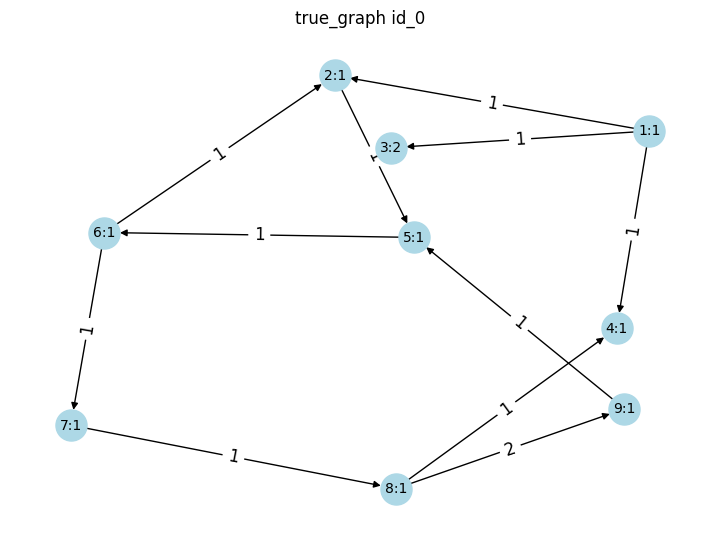

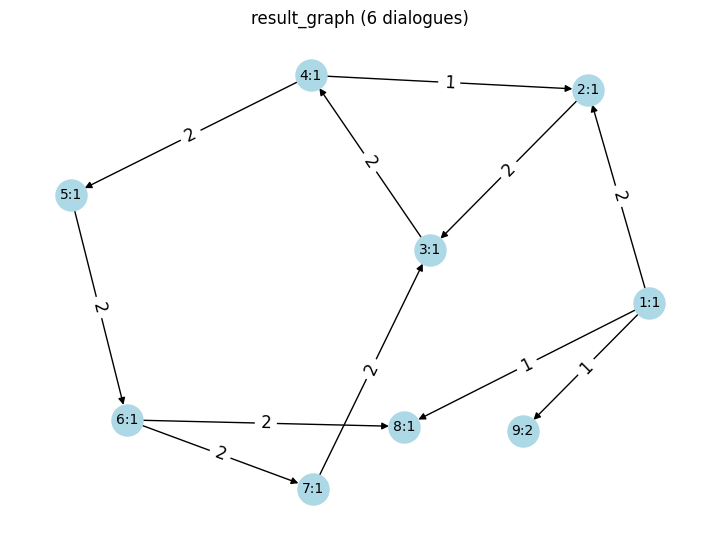

Graphs are isomorphic
(11, 11)
{1: ['Hi there! How can I assist you today?'], 2: ['Great! What product are you interested in?'], 3: ['Of course! Our products include t-shirts, hoodies, and caps. How can I help you?', 'Sure! We offer t-shirts, hoodies, and caps. What would you like to know?'], 4: ['Alright, feel free to reach out anytime. Have a great day!'], 5: ['What size would you like?'], 6: ['Would you like that in red or blue?'], 7: ['Perfect! Can I have your shipping address?'], 8: ['Thank you! Your order has been placed. Is there anything else I can help you with?'], 9: ['Of course! What would you like to change?']}


In [9]:
with open("../data/gen24_graphid0_incrementation.json", 'r', encoding="utf-8") as f:
    example = json.load(f)
true_graph = Graph(example['graph'])
graphs = [graph for graph in example['incremental'].values()]
result_graph = Graph(graphs[-1])
print(f'is_same_structure:', is_same_structure(true_graph,result_graph), '\n----------------')
print(f'----------------\ntriplet_match_accuracy:', triplet_match_accuracy(true_graph,result_graph))
true_graph.visualise_short('true_graph id_0')
result_graph.visualise_short(f'result_graph ({len(graphs)} dialogues)')
graph_build_result[0] = triplet_match_accuracy(true_graph,result_graph)

is_same_structure: False 
----------------
(9, 8)
{1: ["Hello! I'm sorry you're experiencing issues. How can I assist you today?"], 2: ["I'm sorry to hear that you're having trouble with your account. Can you please provide more details?"], 3: ['Have you tried resetting your password?'], 4: ["I'm sorry resetting your password didn't help. Would you like me to escalate this issue to our support team?"], 5: ['Certainly! Please provide your new email address.', 'Of course! What email address would you like to use instead?'], 6: ['Your email has been updated successfully. Is there anything else I can help you with?'], 7: ["I've escalated your issue. You should receive an email with further instructions shortly."], 8: ['Thank you for reaching out. Have a great day!', "We're here to help if you need anything else. Goodbye!"]}
----------------
triplet_match_accuracy: {'node_accuracy': 1.0, 'edge_accuracy': 0.7777777777777778}


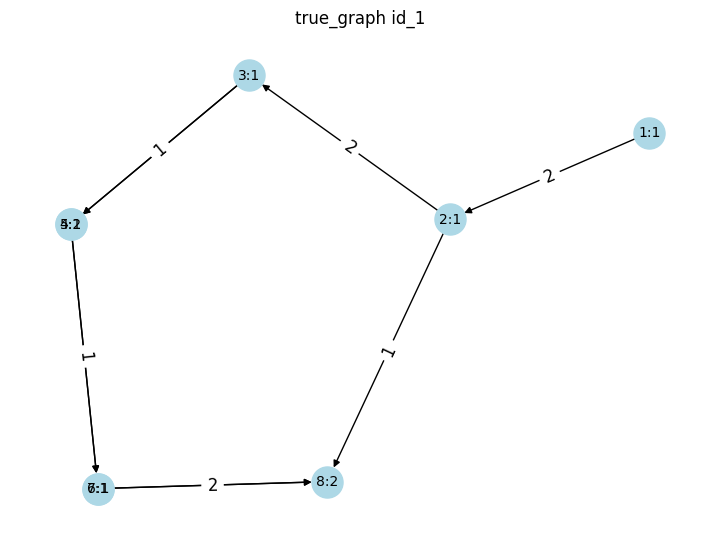

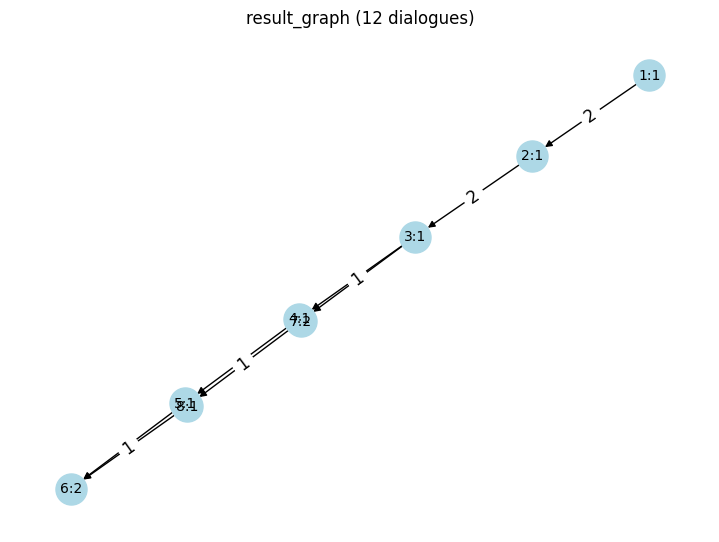

(9, 8)
{1: ["Hello! I'm sorry you're experiencing issues. How can I assist you today?"], 2: ["I'm sorry to hear that you're having trouble with your account. Can you please provide more details?"], 3: ['Have you tried resetting your password?'], 4: ["I'm sorry resetting your password didn't help. Would you like me to escalate this issue to our support team?"], 5: ['Certainly! Please provide your new email address.', 'Of course! What email address would you like to use instead?'], 6: ['Your email has been updated successfully. Is there anything else I can help you with?'], 7: ["I've escalated your issue. You should receive an email with further instructions shortly."], 8: ['Thank you for reaching out. Have a great day!', "We're here to help if you need anything else. Goodbye!"]}


In [10]:
with open("../data/gen24_graphid1_incrementation.json", 'r', encoding="utf-8") as f:
    example = json.load(f)
true_graph = Graph(example['graph'])
graphs = [graph for graph in example['incremental'].values()]
result_graph = Graph(graphs[-1])
print(f'is_same_structure:', is_same_structure(true_graph,result_graph), '\n----------------')
print(f'----------------\ntriplet_match_accuracy:', triplet_match_accuracy(true_graph,result_graph))
true_graph.visualise_short('true_graph id_1')
result_graph.visualise_short(f'result_graph ({len(graphs)} dialogues)')
graph_build_result[1] = triplet_match_accuracy(true_graph,result_graph)

is_same_structure: False 
----------------
(20, 17)
{1: ['Hello! How can I assist you today?'], 2: ["Sure, could you please specify the chatbot limitations you're facing?"], 3: ["I'm sorry to hear that. Can you provide more details about the fake account?"], 4: ['Certainly! Are you looking to respond to positive or negative reviews?'], 5: ['I understand. To help reduce delays, you can try optimizing your response scripts.'], 6: ["I'm sorry the chatbot isn't understanding user queries. You might consider updating its training data."], 7: ['To report impersonation, please visit our support page and submit the account details.'], 8: ['If the account is sending spam messages, you can block and report it directly from the platform.'], 9: ['When responding to negative reviews, maintain professionalism and address the concerns raised.'], 10: ['Acknowledge positive feedback and thank customers for their support to encourage loyalty.'], 11: ['Thank you for reaching out. If you need further assi

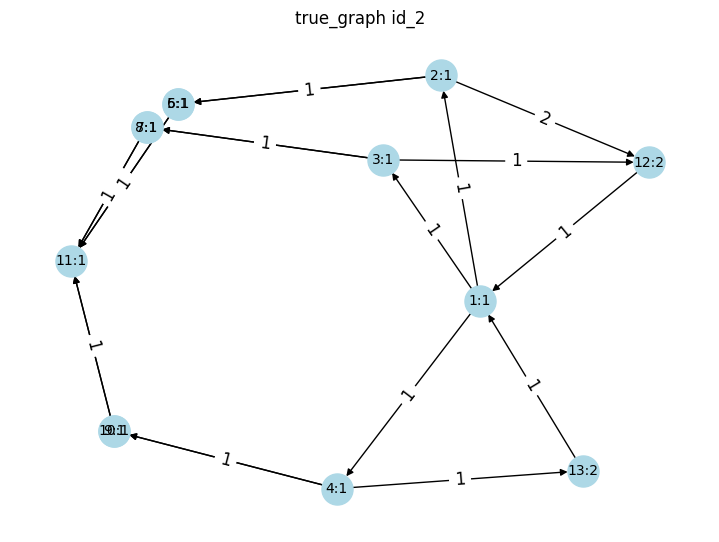

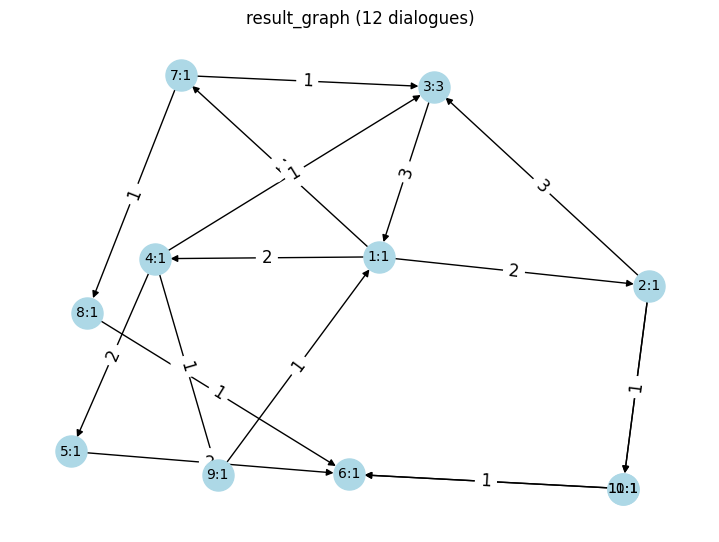

(20, 17)
{1: ['Hello! How can I assist you today?'], 2: ["Sure, could you please specify the chatbot limitations you're facing?"], 3: ["I'm sorry to hear that. Can you provide more details about the fake account?"], 4: ['Certainly! Are you looking to respond to positive or negative reviews?'], 5: ['I understand. To help reduce delays, you can try optimizing your response scripts.'], 6: ["I'm sorry the chatbot isn't understanding user queries. You might consider updating its training data."], 7: ['To report impersonation, please visit our support page and submit the account details.'], 8: ['If the account is sending spam messages, you can block and report it directly from the platform.'], 9: ['When responding to negative reviews, maintain professionalism and address the concerns raised.'], 10: ['Acknowledge positive feedback and thank customers for their support to encourage loyalty.'], 11: ['Thank you for reaching out. If you need further assistance, feel free to ask. Have a great day!

In [11]:
with open("../data/gen24_graphid2_incrementation.json", 'r', encoding="utf-8") as f:
    example = json.load(f)
true_graph = Graph(example['graph'])
graphs = [graph for graph in example['incremental'].values()]
result_graph = Graph(graphs[-1])
print(f'is_same_structure:', is_same_structure(true_graph,result_graph), '\n----------------')
print(f'----------------\ntriplet_match_accuracy:', triplet_match_accuracy(true_graph,result_graph))
true_graph.visualise_short('true_graph id_2')
result_graph.visualise_short(f'result_graph ({len(graphs)} dialogues)')
graph_build_result[2] = triplet_match_accuracy(true_graph,result_graph)

is_same_structure: True 
----------------
Graphs are isomorphic
(13, 13)
{1: ['Hello! How can I assist you with eco-friendly packaging today?', 'Hi there! What would you like to know about eco-friendly packaging?'], 2: ['Sure! There are several types of eco-friendly packaging such as biodegradable materials, recyclable plastics, and compostable containers. Would you like more details on any of these?'], 3: ['Absolutely! For businesses, sustainable packaging options include using recycled materials, reducing packaging size, and opting for reusable containers. Which of these are you interested in?'], 4: ['Eco-friendly packaging costs can vary based on materials and volume. Generally, they might be slightly more expensive upfront but can lead to savings in the long run through sustainability certifications and consumer preferences. Would you like a detailed cost analysis?'], 5: ['Of course! What types of eco-friendly packaging are you interested in exploring?'], 6: ['No problem! Which sus

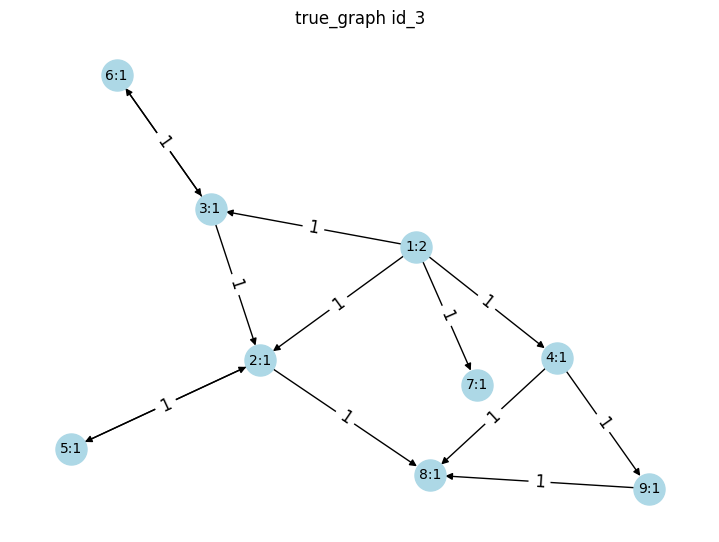

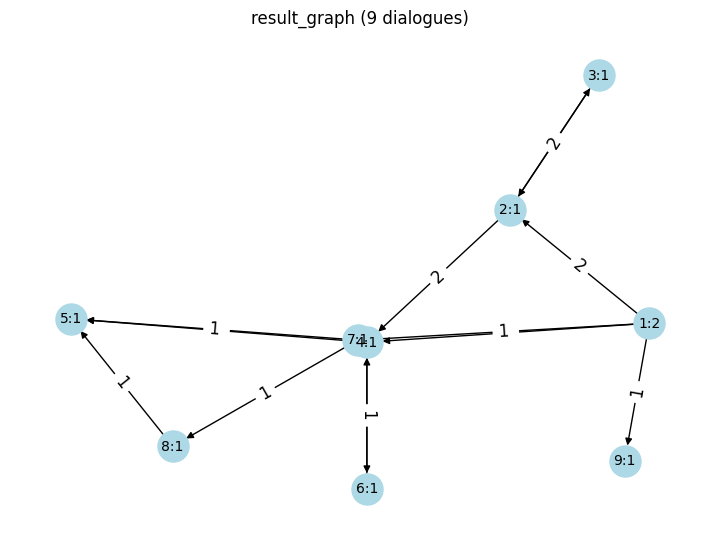

Graphs are isomorphic
(13, 13)
{1: ['Hello! How can I assist you with eco-friendly packaging today?', 'Hi there! What would you like to know about eco-friendly packaging?'], 2: ['Sure! There are several types of eco-friendly packaging such as biodegradable materials, recyclable plastics, and compostable containers. Would you like more details on any of these?'], 3: ['Absolutely! For businesses, sustainable packaging options include using recycled materials, reducing packaging size, and opting for reusable containers. Which of these are you interested in?'], 4: ['Eco-friendly packaging costs can vary based on materials and volume. Generally, they might be slightly more expensive upfront but can lead to savings in the long run through sustainability certifications and consumer preferences. Would you like a detailed cost analysis?'], 5: ['Of course! What types of eco-friendly packaging are you interested in exploring?'], 6: ['No problem! Which sustainable packaging options would you like 

In [12]:
with open("../data/gen24_graphid3_incrementation.json", 'r', encoding="utf-8") as f:
    example = json.load(f)
true_graph = Graph(example['graph'])
graphs = [graph for graph in example['incremental'].values()]
result_graph = Graph(graphs[-1])
print(f'is_same_structure:', is_same_structure(true_graph,result_graph), '\n----------------')
print(f'----------------\ntriplet_match_accuracy:', triplet_match_accuracy(true_graph,result_graph))
true_graph.visualise_short('true_graph id_3')
result_graph.visualise_short(f'result_graph ({len(graphs)} dialogues)')
graph_build_result[3] = triplet_match_accuracy(true_graph,result_graph)

is_same_structure: False 
----------------
(16, 13)
{1: ['Hello! How can I assist you today?'], 2: ['I understand you have concerns about ethical sourcing. Could you please elaborate on what specifically worries you?'], 3: ['We ensure ethical standards by regularly auditing our suppliers and requiring certifications such as Fair Trade. Would you like more details on our auditing process?'], 4: ['We take the environmental impact seriously by using sustainable materials and reducing our carbon footprint. Would you like to know about our sustainability initiatives?'], 5: ["Sure, let's focus on labor practices. We ensure fair wages and safe working conditions through our comprehensive policies. Do you have specific questions on labor ethics?"], 6: ['Absolutely! Our auditing process includes on-site visits and regular reporting to ensure compliance. Do you have any other questions?', 'Certainly! We conduct thorough inspections and partner with third-party auditors to maintain our standards.

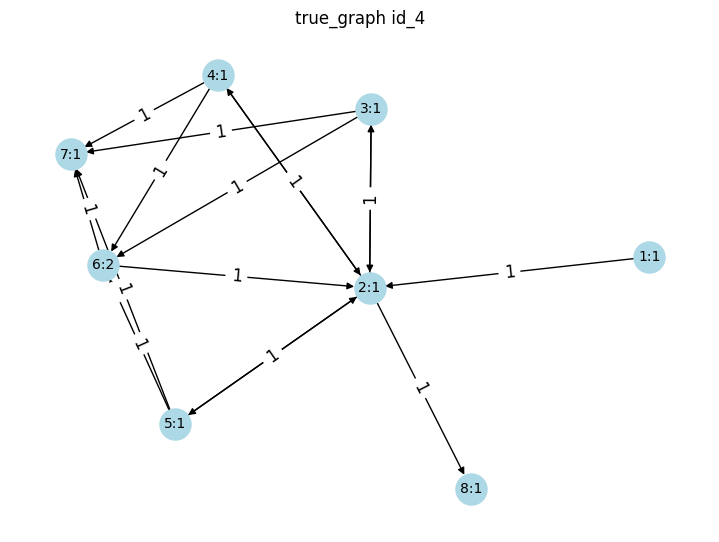

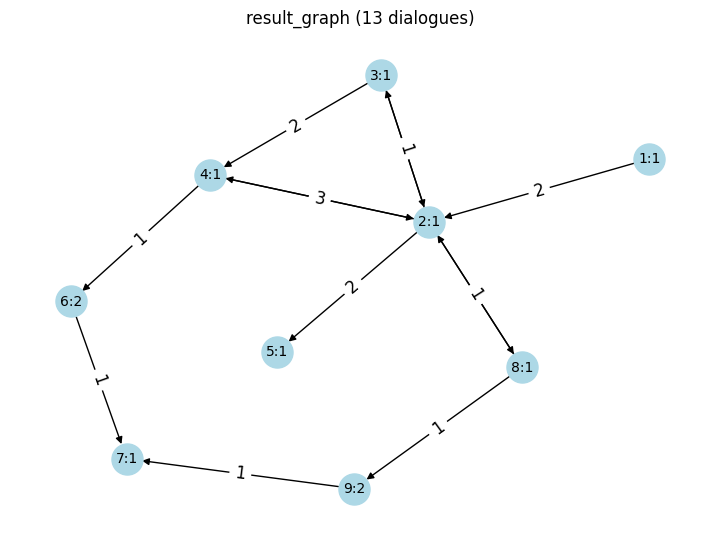

(16, 13)
{1: ['Hello! How can I assist you today?'], 2: ['I understand you have concerns about ethical sourcing. Could you please elaborate on what specifically worries you?'], 3: ['We ensure ethical standards by regularly auditing our suppliers and requiring certifications such as Fair Trade. Would you like more details on our auditing process?'], 4: ['We take the environmental impact seriously by using sustainable materials and reducing our carbon footprint. Would you like to know about our sustainability initiatives?'], 5: ["Sure, let's focus on labor practices. We ensure fair wages and safe working conditions through our comprehensive policies. Do you have specific questions on labor ethics?"], 6: ['Absolutely! Our auditing process includes on-site visits and regular reporting to ensure compliance. Do you have any other questions?', 'Certainly! We conduct thorough inspections and partner with third-party auditors to maintain our standards.'], 7: ["If that's all, I'm glad I could he

In [13]:
with open("../data/gen24_graphid4_incrementation.json", 'r', encoding="utf-8") as f:
    example = json.load(f)
true_graph = Graph(example['graph'])
graphs = [graph for graph in example['incremental'].values()]
result_graph = Graph(graphs[-1])
print(f'is_same_structure:', is_same_structure(true_graph,result_graph), '\n----------------')
print(f'----------------\ntriplet_match_accuracy:', triplet_match_accuracy(true_graph,result_graph))
true_graph.visualise_short('true_graph id_4')
result_graph.visualise_short(f'result_graph ({len(graphs)} dialogues)')
graph_build_result[4] = triplet_match_accuracy(true_graph,result_graph)

In [14]:
graph_build_result

{0: {'node_accuracy': 1.0, 'edge_accuracy': 1.0},
 1: {'node_accuracy': 1.0, 'edge_accuracy': 0.7777777777777778},
 2: {'node_accuracy': 0.8461538461538461, 'edge_accuracy': 0.8},
 3: {'node_accuracy': 1.0, 'edge_accuracy': 1.0},
 4: {'node_accuracy': 1.0, 'edge_accuracy': 0.6875}}

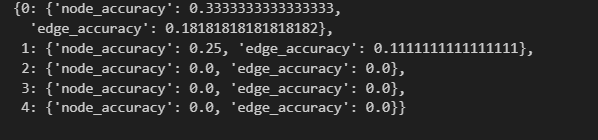
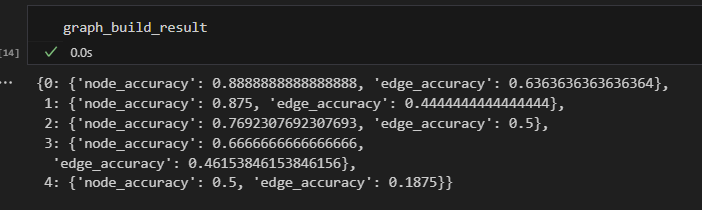
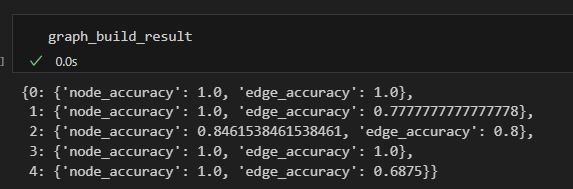


# Выводы:

| Модель | node_accuracy | edge_accuracy |
|-----------|-----------|-----------|
| **gpt-4o** | 0.116  | 0.058  |
| **gpt-4o-mini**  | 0.74 | 0.4459 |
| **o3-mini**  | 0.969  | 0.8515 |